# Effects of Random-Loss Incentive on Self-Tracking Compliance

This notebook shows steps used for reproducing results and figures in the paper:

Achananuparp, P., Lim, E.-P., Abhishek, V., & Yun, T. (2018). Eat & Tell: A Randomized Trial of Random-Loss Incentive to Increase Dietary Self-Tracking Compliance. In Proceedings of the 2018 International Conference on Digital Health - DH ’18. https://doi.org/10.1145/3194658.3194662

It consists of the following sections:

* Exploratory data analysis
* Hypothesis testing
* Mixed effects logistic regression
* Pre/post-intervention food logging statistics

It should take approximately 5 minutes to run on an Intel Core i5-7200U machine with 8GB of RAM.

In [1]:
options(warn=-1)
t0 <- proc.time()

## 1. Loading packages and data

In [2]:
library(effects)
library(dplyr)
library(ggplot2)
library(lme4)

users_df <- read.csv("../data/users.csv")
demos_df <- read.csv("../data/demos.csv")
deducs_df <- read.csv("../data/deductions.csv")
deducs_df$weekday <- weekdays(as.Date(deducs_df$task_date))
eod_df <- read.csv("../data/end-of-days.csv")
deducs_7d_df <- read.csv("../data/deductions_7d.csv")
eod_7d_df <- read.csv("../data/end-of-days_7d.csv")
pre_diary_df <- read.csv("../data/pre_food_diaries.csv")
pre_diary_df <- summarize(group_by(pre_diary_df, user_id), prior_diary_days=n_distinct(diary_date))
post_diary_df <- read.csv("../data/post_food_diaries.csv")
post_diary_df <- summarize(group_by(post_diary_df, user_id), post_diary_days=n_distinct(diary_date))
post_diary_df$post_diary_days[post_diary_df$post_diary_days>30] <- 30

complete_rates <- summarize(group_by(filter(deducs_df, day_index >= 1 & day_index <= 30), user_id), completed_days=sum(complete_flag), completion_rate=mean(complete_flag))
complete_rates <- merge(complete_rates, users_df)

print("Done")

Loading required package: carData
lattice theme set by effectsTheme()
See ?effectsTheme for details.

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix


[1] "Done"


## 2. Exploratory data analysis

### Data characterisics. 

Table 1 in the paper.

In [3]:
nrow(users_df)
nrow(demos_df)
df <- merge(users_df, demos_df, x.all=TRUE)
# gender
summarize(group_by(df, gender, experiment_id), n=n())

# age range
df$age_range = cut(df$age, breaks=seq(17,25,by=7), right=TRUE)
summarize(group_by(df, age_range, experiment_id), n=n())
df$age_range = cut(df$age, breaks=seq(24,35,by=10), right=TRUE)
summarize(group_by(df, age_range, experiment_id), n=n())
df$age_range = cut(df$age, breaks=seq(34,45,by=10), right=TRUE)
summarize(group_by(df, age_range, experiment_id), n=n())
df$age_range = cut(df$age, breaks=seq(44,55,by=10), right=TRUE)
summarize(group_by(df, age_range, experiment_id), n=n())
df$age_range = cut(df$age, breaks=seq(54,65,by=10), right=TRUE)
summarize(group_by(df, age_range, experiment_id), n=n())
df$age_range = cut(df$age, breaks=seq(64,75,by=10), right=TRUE)
summarize(group_by(df, age_range, experiment_id), n=n())

# ethnicity, education, employment, marital status
summarize(group_by(df, ethnicity, experiment_id), n=n())
summarize(group_by(df, education, experiment_id), n=n())
summarize(group_by(df, employment, experiment_id), n=n())
summarize(group_by(df, marital, experiment_id), n=n())

# bmi and grit scores
summarize(group_by(filter(df, !is.na(bmi)), experiment_id), bmi=mean(bmi))
summarize(group_by(filter(df, !is.na(grit)), experiment_id), grit=mean(grit))

[1] 245

[1] 204

gender,experiment_id,n
female,Fixed,66
female,Random,85
male,Fixed,22
male,Random,31


age_range,experiment_id,n
"(17,24]",Fixed,22
"(17,24]",Random,19
NA,Fixed,66
NA,Random,97


age_range,experiment_id,n
"(24,34]",Fixed,40
"(24,34]",Random,55
NA,Fixed,48
NA,Random,61


age_range,experiment_id,n
"(34,44]",Fixed,14
"(34,44]",Random,21
NA,Fixed,74
NA,Random,95


age_range,experiment_id,n
"(44,54]",Fixed,6
"(44,54]",Random,6
NA,Fixed,82
NA,Random,110


age_range,experiment_id,n
"(54,64]",Random,3
NA,Fixed,88
NA,Random,113


age_range,experiment_id,n
"(64,74]",Random,1
NA,Fixed,88
NA,Random,115


ethnicity,experiment_id,n
chinese,Fixed,83
chinese,Random,111
indian,Fixed,4
indian,Random,3
malay,Random,1
others,Fixed,1
others,Random,1


education,experiment_id,n
i-prefer-not-to-say,Random,3
ite-and-other-vocational-certificate,Fixed,4
ite-and-other-vocational-certificate,Random,1
junior-college,Fixed,5
junior-college,Random,7
polytechnic-diploma,Fixed,14
polytechnic-diploma,Random,17
secondary,Fixed,3
secondary,Random,8
university-or-higher,Fixed,62


employment,experiment_id,n
entrepreneur,Fixed,2
entrepreneur,Random,1
full-time-employment,Fixed,57
full-time-employment,Random,78
homemaker,Fixed,5
homemaker,Random,3
i-prefer-not-to-say,Random,5
others,Fixed,2
others,Random,4
part-time-employment,Fixed,4


marital,experiment_id,n
divorced,Random,2
i-prefer-not-to-say,Fixed,1
i-prefer-not-to-say,Random,3
living-with-a-partner,Random,2
married,Fixed,27
married,Random,39
never-been-married,Fixed,60
never-been-married,Random,70


experiment_id,bmi
Fixed,22.49234
Random,23.15818


experiment_id,grit
Fixed,2.777500
Random,2.726638


### Test of equal proportions

Equal proportions of __male/female users__ in the treatment and control groups ($\chi^2$=0.07735, p=0.7809)

In [4]:
prop.test(c(111,91), c(135,110), correct=FALSE) # intervention participants, treatment vs control

# male ratio, treatment vs. control
df <- merge(users_df, demos_df, x.all=TRUE)
tab <- table(df$experiment_id, df$gender)
tab
prop.test(tab, correct=FALSE)


	2-sample test for equality of proportions without continuity
	correction

data:  c(111, 91) out of c(135, 110)
X-squared = 0.010684, df = 1, p-value = 0.9177
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.10070368  0.09060267
sample estimates:
   prop 1    prop 2 
0.8222222 0.8272727 


        
         female male
  Fixed      66   22
  Random     85   31


	2-sample test for equality of proportions without continuity
	correction

data:  tab
X-squared = 0.07735, df = 1, p-value = 0.7809
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.1038777  0.1383604
sample estimates:
   prop 1    prop 2 
0.7500000 0.7327586 


Equal proportions of __full/partial compliant users__ in the treatment and control groups ($\chi^2$=0.010684, p=0.9177)

In [5]:
df <- merge(users_df, complete_rates, x.all=TRUE)
df$compliance <- "FullC"
df$compliance[df$completed_days<30] <- "PartialC" 
tab <- table(df$experiment_id, df$compliance)
tab
prop.test(tab, correct=FALSE)

        
         FullC PartialC
  Fixed     19       91
  Random    24      111


	2-sample test for equality of proportions without continuity
	correction

data:  tab
X-squared = 0.010684, df = 1, p-value = 0.9177
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.10070368  0.09060267
sample estimates:
   prop 1    prop 2 
0.1727273 0.1777778 


### Distribution of random losses

Figure 2 in the paper.

mean,sd
0.9983395,0.5837584


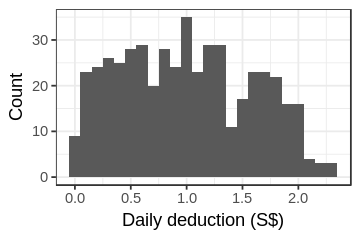

In [6]:
losses_df <- read.csv("../data/deduction_amounts.csv")
summarize(filter(losses_df, experiment_id=="Random"), mean=mean(amount), sd=sd(amount))
options(repr.plot.width=3, repr.plot.height=2)
p1 <- ggplot(filter(losses_df, experiment_id=="Random"), aes(x=amount)) +
    geom_histogram(binwidth=0.1) +
    scale_x_continuous(name="Daily deduction (S$)") +
    scale_y_continuous(name="Count") +
    theme(plot.margin = unit(c(6,0,6,0), "pt")) +
    theme_bw()
p1
ggsave("../reports/figures/hist_losses.pdf", width=3, height=2, units='in', device = cairo_pdf)

### Distributions of caloric intake and dairy entries
Figures 3 and 4 in the paper.

In [7]:
diaries_df <- read.csv("../data/food_diaries.csv")
user_cals_data <- summarize(group_by(diaries_df, user_id, diary_date), sum_cal=sum(calories))
user_entries_data <- summarize(group_by(diaries_df, user_id, diary_date), nrows=n())

In [8]:
user_cals_data <- merge(user_cals_data, users_df, by="user_id")
user_entries_data <- merge(user_entries_data, users_df, by="user_id")

user_id,diary_date,sum_cal,end_date,experiment_id,food_journal_app,username
43,2017-06-12,119705,2017-07-08,Random,MyFitnessPal,user_43
43,2017-06-14,119340,2017-07-08,Random,MyFitnessPal,user_43
43,2017-06-21,119340,2017-07-08,Random,MyFitnessPal,user_43


experiment_id,mean_cal,median_cal,sd_cal,max_cal
Fixed,1263.051,1258,492.3983,3529
Random,1249.046,1226,520.1429,3531


mean_cal,median_cal,sd_cal,max_cal
1254.849,1239,508.8259,3531


experiment_id,mean_nrows,median_nrows,sd_nrows,max_nrows
Fixed,5.805970,5,3.377106,26
Random,6.234529,6,3.808028,25


mean_nrows,median_nrows,sd_nrows,max_nrows
6.057066,5,3.641553,26


[1] 0.1479192


	Welch Two Sample t-test

data:  sum_cal by experiment_id
t = 0.95324, df = 4464.8, p-value = 0.3405
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -14.79862  42.80860
sample estimates:
 mean in group Fixed mean in group Random 
            1263.051             1249.046 



	Wilcoxon rank sum test with continuity correction

data:  nrows by experiment_id
W = 2704500, p-value = 0.00131
alternative hypothesis: true location shift is not equal to 0


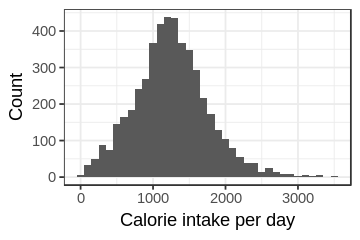

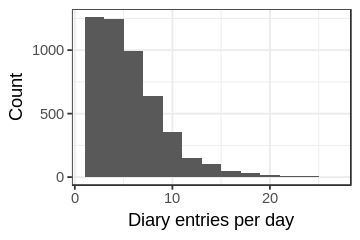

In [9]:
filter(user_cals_data, abs(sum_cal - median(sum_cal)) > 2*sd(sum_cal))
user_cals_data <- filter(user_cals_data, !abs(sum_cal - median(sum_cal)) > 2*sd(sum_cal))
summarize(group_by(user_cals_data, experiment_id), mean_cal=mean(sum_cal), median_cal=median(sum_cal), sd_cal=sd(sum_cal), max_cal=max(sum_cal))
summarize(user_cals_data, mean_cal=mean(sum_cal), median_cal=median(sum_cal), sd_cal=sd(sum_cal), max_cal=max(sum_cal))
summarize(group_by(user_entries_data, experiment_id), mean_nrows=mean(nrows), median_nrows=median(nrows), sd_nrows=sd(nrows), max_nrows=max(nrows))
summarize(user_entries_data, mean_nrows=mean(nrows), median_nrows=median(nrows), sd_nrows=sd(nrows), max_nrows=max(nrows))
# arrange(user_cals_data, desc(sum_cal))
nrow(filter(user_entries_data, nrows>=10))/nrow(user_entries_data)

t.test(sum_cal ~ experiment_id, user_cals_data, paired=FALSE) 
wilcox.test(nrows ~ experiment_id, user_entries_data, paired=FALSE)
options(repr.plot.width=3, repr.plot.height=2)
p1 <- ggplot(user_cals_data, aes(x=sum_cal)) + 
    geom_histogram(binwidth=100) +
    scale_x_continuous(name="Calorie intake per day") +
    scale_y_continuous(name="Count") +
    theme(plot.margin = unit(c(6,0,6,0), "pt")) +
    theme_bw()
p1
ggsave("../reports/figures/hist_calories.pdf", width=3, height=2, units='in', device = cairo_pdf)
p2 <- ggplot(user_entries_data, aes(x=nrows)) + 
    geom_histogram(binwidth=2) +
    scale_x_continuous(name="Diary entries per day") +
    scale_y_continuous(name="Count") +
    theme(plot.margin = unit(c(6,0,6,0), "pt")) +
    theme_bw()
p2
ggsave("../reports/figures/hist_entries.pdf", width=3, height=2, units='in', device = cairo_pdf)

### Distribution of compliance days
Only include full-treatment participants who have 1 non-compliance day or more (i.e., completed_days<30). 

Figure 5 in the paper.

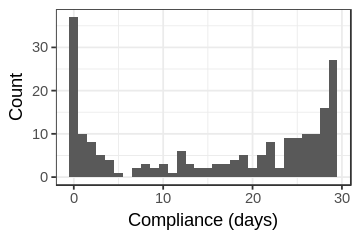

In [10]:
options(repr.plot.width=3, repr.plot.height=2)
p <- ggplot(filter(complete_rates, completed_days<30), aes(x=completed_days)) + 
    geom_histogram(binwidth=1) +
    scale_x_continuous(name="Compliance (days)") +
    scale_y_continuous(name="Count") +
    theme(plot.margin = unit(c(6,0,6,0), "pt")) +
    theme_bw()
p
ggsave("../reports/figures/hist_compliance.pdf", width=3, height=2, units='in', device = cairo_pdf)

Figure 6 in the paper.

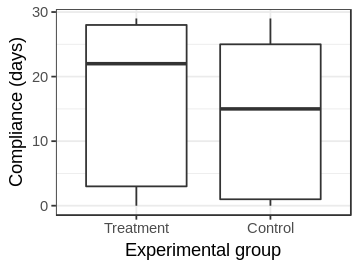

In [11]:
options(repr.plot.width=3, repr.plot.height=2.25)

p1 <- ggplot(filter(complete_rates, completed_days < 30), aes(x=factor(experiment_id, levels=c("Random", "Fixed")), y=completed_days)) + 
        geom_boxplot() + 
        scale_x_discrete(name="Experimental group", labels=c("Treatment", "Control")) +
        scale_y_continuous(name="Compliance (days)") +
        theme_bw()
p1
ggsave("../reports/figures/boxplot_completion_days.pdf", width=3, height=2.5, units='in', device = cairo_pdf)

### Participant compliance over time

Figure 7 in the paper.

In [12]:
df <- merge(deducs_df, users_df, by="user_id")
df <- merge(df, eod_df, by=c("user_id", "day_index"), all.x=TRUE)
# this filters out full-compliance participants
df <- merge(df, select(filter(complete_rates, completed_days < 30), user_id, completion_rate), by="user_id")

experiment_id,day_index,num_completes,num_users,pct_completes
Fixed,30,25,89,28.08989
Random,30,51,111,45.94595


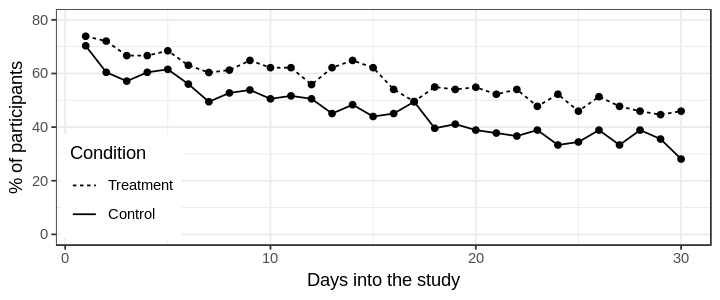

In [13]:
data <- summarize(group_by(df, experiment_id, day_index), num_completes=sum(complete_flag), num_users=n())
data$pct_completes <- 100*data$num_completes/data$num_users
options(repr.plot.width=6, repr.plot.height=2.5)

filter(data, day_index==30)

my_theme <- theme_set(theme_bw())
my_theme <- theme_update(legend.position = c(0.1, 0.25))

p <- ggplot(data, aes(x=day_index, y=pct_completes, fill=experiment_id)) + 
    geom_point(show.legend=FALSE) +
    scale_shape_discrete(guide=FALSE) +
    geom_line(aes(linetype=experiment_id)) +
    scale_x_continuous(name="Days into the study") +
    scale_y_continuous(name="% of participants", limit=c(0,80)) +
    scale_linetype_discrete(name="Condition", breaks=c("Random", "Fixed"), labels=c("Treatment", "Control"))
p
ggsave("../reports/figures/lines_completion_days.pdf", width=6, height=2.5, units='in', device = cairo_pdf)

## 3. Hypothesis testing

To evaluate the overall effectiveness of the treament, we perform a hypothesis testing using Mann-Whitney U test.

H0: rank_sum(treatment) = rank_sum(control)  
H1: rank_sum(treatment) != rank_sum(control)

In [14]:
hypo.test <- function(complete_rates){
    IRdisplay::display(nrow(complete_rates))
    users.count<- summarize(group_by(complete_rates, experiment_id), count=n())
    IRdisplay::display(users.count)
    comp_days.mean <- summarize(group_by(complete_rates, experiment_id), mean=mean(completed_days))
    comp_days.median <- summarize(group_by(complete_rates, experiment_id), median=median(completed_days))
    comp_rate.mean <- summarize(group_by(complete_rates, experiment_id), mean=mean(completion_rate))
    comp_rate.median <- summarize(group_by(complete_rates, experiment_id), median=median(completion_rate))
    wilcox.test(completion_rate ~ experiment_id, complete_rates, paired=FALSE) 
}

### Modified intention-to-treat analysis (mITT)

Our exclusion criteria:

1. Exclude subjects who did not receive any deduction.
2. Exclude subjects who did not complete any daily task.
3. Exclude subjects who did not complete any daily task or did not receive any deduction.

Statistics:
* N = 202
* U = 4142, p-value = 0.02729. Significant at $\alpha$ = 0.05.
* Treatment is 46.67% better than control

Uncontrolled, the random-loss incentive is more effective than the fixed-loss incentive.

In [15]:
hypo.test(filter(complete_rates, completed_days < 30))

[1] 202

experiment_id,count
Fixed,91
Random,111



	Wilcoxon rank sum test with continuity correction

data:  completion_rate by experiment_id
W = 4142, p-value = 0.02729
alternative hypothesis: true location shift is not equal to 0


## 4. Mixed effects logistic regression

### Modified intention-to-treat analysis (mITT)

Our exclusion criteria:

1. Exclude subjects who did not receive any deduction.
2. Exclude subjects who did not complete any daily task.
3. Exclude subjects who did not complete any daily task or did not receive any deduction.

Statistics:
* Number of rows = 6050
* Number of subjects = 202

In [16]:
df <- merge(users_df, deducs_df, by="user_id", all.x=TRUE)
df <- merge(df, demos_df, by="user_id", all.x=TRUE)
df <- merge(df, eod_df, by=c("user_id", "day_index"), all.x=TRUE)
df <- merge(df, pre_diary_df, by="user_id", all.x=TRUE)
df$prior_diary_days[is.na(df$prior_diary_days)] <- 0
df <- merge(df, select(complete_rates, user_id, completion_rate), by="user_id", all.x=TRUE)
df <- filter(df, day_index >= 1 & day_index <= 30 & completion_rate < 1)
nrow(df)
length(unique(df$user_id))

[1] 6050

[1] 202

### Model selection

8 Models corresponding to those in Section 6.2 in the paper.

* Model 1 (mitt.1.m.1)
* Model 2 (mitt.1.m.2)
* Model 3 (mitt.1.m.3)
* Model 4 (mitt.1.m.4)
* Model 5 (mitt.1.m.5)
* Model 6 (mitt.1.m.6)
* Model 7 (mitt.1.m.7)
* Model 8 (mitt.1.m.8)

In [17]:
mitt.1.m.1 <- glmer(complete_flag ~ experiment_id + (1|user_id), family=binomial, data=df)
mitt.1.m.2 <- glmer(complete_flag ~ experiment_id + day_index + (1|user_id), family=binomial, data=df)
mitt.1.m.3 <- glmer(complete_flag ~ experiment_id + experiment_id:day_index + day_index + (1|user_id), family=binomial, data=df)
mitt.1.m.4 <- glmer(complete_flag ~ experiment_id + experiment_id:day_index + day_index + prior_diary_days + (1|user_id), family=binomial, data=df)
mitt.1.m.5 <- glmer(complete_flag ~ experiment_id + experiment_id:day_index + day_index + prior_diary_days + eff_survey + (1+eff_survey|user_id), 
                 family=binomial, data=df, control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=100000)))
mitt.1.m.6 <- glmer(complete_flag ~ experiment_id + experiment_id:day_index + experiment_id:gender + day_index + prior_diary_days + eff_survey + gender + (1+eff_survey|user_id), 
                 family=binomial, data=df, control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=100000)))
mitt.1.m.7 <- glmer(complete_flag ~ experiment_id + experiment_id:day_index + experiment_id:gender + experiment_id:age + day_index + prior_diary_days + eff_survey + gender + age + (1+eff_survey|user_id), 
                 family=binomial, data=df, control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=100000)))
mitt.1.m.8 <- glmer(complete_flag ~ experiment_id + experiment_id:day_index + experiment_id:gender + experiment_id:age + experiment_id:grit + day_index + prior_diary_days + eff_survey + gender + age + grit + (1+eff_survey|user_id), 
                 family=binomial, data=df, control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=1000000)))

Results for each model below.

In [18]:
summary(mitt.1.m.1)
summary(mitt.1.m.1)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: complete_flag ~ experiment_id + (1 | user_id)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  4779.5   4799.6  -2386.8   4773.5     6047 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6965 -0.2198  0.2163  0.4089  4.7285 

Random effects:
 Groups  Name        Variance Std.Dev.
 user_id (Intercept) 8.415    2.901   
Number of obs: 6050, groups:  user_id, 202

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)          -0.7148     0.3163   -2.26   0.0238 *
experiment_idRandom   0.9095     0.4250    2.14   0.0324 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exprmnt_dRn -0.742

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-0.7148457,0.3163364,-2.259764,0.02383587
experiment_idRandom,0.9095020,0.4249974,2.140018,0.03235333


In [19]:
summary(mitt.1.m.2)
summary(mitt.1.m.2)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: complete_flag ~ experiment_id + day_index + (1 | user_id)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  4354.4   4381.3  -2173.2   4346.4     6046 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-11.2086  -0.1976   0.1111   0.3597   3.1305 

Random effects:
 Groups  Name        Variance Std.Dev.
 user_id (Intercept) 10.47    3.236   
Number of obs: 6050, groups:  user_id, 202

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.789333   0.359840   2.194   0.0283 *  
experiment_idRandom  1.015318   0.472844   2.147   0.0318 *  
day_index           -0.102154   0.005242 -19.486   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) expr_R
exprmnt_dRn -0.721       
day_index   -0.211 -0.019

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.7893330,0.359839927,2.193567,2.826655e-02
experiment_idRandom,1.0153181,0.472843735,2.147259,3.177264e-02
day_index,-0.1021535,0.005242452,-19.485832,1.448056e-84


In [20]:
summary(mitt.1.m.3)
summary(mitt.1.m.3)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: complete_flag ~ experiment_id + experiment_id:day_index + day_index +  
    (1 | user_id)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  4350.8   4384.3  -2170.4   4340.8     6045 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.0067  -0.1986   0.1118   0.3544   2.9986 

Random effects:
 Groups  Name        Variance Std.Dev.
 user_id (Intercept) 10.52    3.243   
Number of obs: 6050, groups:  user_id, 202

Fixed effects:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    1.009377   0.372316   2.711  0.00671 ** 
experiment_idRandom            0.607693   0.501792   1.211  0.22588    
day_index                     -0.116622   0.008089 -14.418  < 2e-16 ***
experiment_idRandom:day_index  0.025661   0.010524   2.438  0.01475 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),1.00937741,0.37231629,2.711075,6.706544e-03
experiment_idRandom,0.60769320,0.50179156,1.211047,2.258774e-01
day_index,-0.11662231,0.00808858,-14.418145,3.978948e-47
experiment_idRandom:day_index,0.02566098,0.01052392,2.438349,1.475451e-02


Interaction effect of interventions and days into the study. Figure 8 in the paper.

experiment_id,day_index,fit,se,lower,upper
Fixed,1.0,0.70945840,0.3697994,0.54189194,0.8344568
Random,1.0,0.82143634,0.3342869,0.70493689,0.8985576
Fixed,8.2,0.51326550,0.3566037,0.34392397,0.6796154
Random,8.2,0.70499278,0.3223334,0.55957215,0.8180140
Fixed,16.0,0.29805446,0.3527560,0.17537985,0.4587960
Random,16.0,0.54033450,0.3175735,0.38680950,0.6865678
Fixed,23.0,0.15803315,0.3588389,0.08500200,0.2749553
Random,23.0,0.38342404,0.3208606,0.24900700,0.5383832
Fixed,30.0,0.07661227,0.3735044,0.03837025,0.1471367
Random,30.0,0.24754118,0.3310907,0.14670329,0.3863115


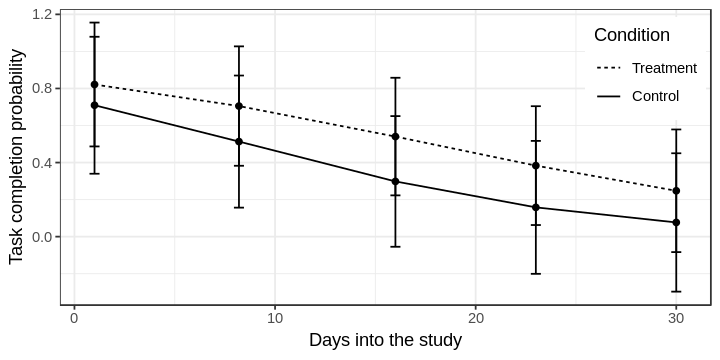

In [21]:
ef <- effect("experiment_id:day_index", mitt.1.m.3)
x <- as.data.frame(ef)
x
options(repr.plot.width=6, repr.plot.height=3)

my_theme <- theme_set(theme_bw())
my_theme <- theme_update(legend.position = c(0.9, 0.8))

p <- ggplot(x, aes(x=day_index, y=fit)) + 
    geom_point() +
    geom_line(aes(linetype=experiment_id)) + 
    geom_errorbar(aes(ymin=fit-se, ymax=fit+se), width=0.5) +
    scale_x_continuous(name="Days into the study") +
    scale_y_continuous(name="Task completion probability") +
    scale_linetype_discrete(name="Condition", breaks=c("Random", "Fixed"), labels=c("Treatment", "Control"))
    
p
ggsave("../reports/figures/interaction.pdf", width=6, height=3, units='in', device = cairo_pdf)

In [22]:
summary(mitt.1.m.4)
summary(mitt.1.m.4)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: complete_flag ~ experiment_id + experiment_id:day_index + day_index +  
    prior_diary_days + (1 | user_id)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  4347.8   4388.0  -2167.9   4335.8     6044 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.9343  -0.1964   0.1115   0.3547   3.0106 

Random effects:
 Groups  Name        Variance Std.Dev.
 user_id (Intercept) 10.26    3.204   
Number of obs: 6050, groups:  user_id, 202

Fixed effects:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    0.806614   0.379648   2.125   0.0336 *  
experiment_idRandom            0.621421   0.496891   1.251   0.2111    
day_index                     -0.116739   0.008095 -14.422   <2e-16 ***
prior_diary_days               0.112897   0.050116   2.253   0.0243 *  
experiment_idRandom:day_inde

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.80661403,0.379647828,2.124638,3.361687e-02
experiment_idRandom,0.62142058,0.496891244,1.250617,2.110743e-01
day_index,-0.11673922,0.008094769,-14.421563,3.786715e-47
prior_diary_days,0.11289654,0.050115912,2.252708,2.427754e-02
experiment_idRandom:day_index,0.02585374,0.010526578,2.456044,1.404759e-02


In [23]:
summary(mitt.1.m.5)
summary(mitt.1.m.5)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: complete_flag ~ experiment_id + experiment_id:day_index + day_index +  
    prior_diary_days + eff_survey + (1 + eff_survey | user_id)
   Data: df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
   824.8    879.8   -403.4    806.8     3307 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-20.4652   0.0097   0.0226   0.0738   2.0785 

Random effects:
 Groups  Name        Variance Std.Dev. Corr 
 user_id (Intercept) 9.806    3.132         
         eff_survey  3.073    1.753    -0.45
Number of obs: 3316, groups:  user_id, 168

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    5.77795    1.45509   3.971 7.16e-05 ***
experiment_idRandom           -1.63752    0.97309  -1.683  0.09241 .  
day_index       

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),5.77794624,1.45509081,3.9708492,7.161689e-05
experiment_idRandom,-1.63752327,0.97309266,-1.6828030,9.241323e-02
day_index,-0.16768907,0.02941321,-5.7011485,1.190029e-08
prior_diary_days,-0.03017467,0.07130108,-0.4232008,6.721488e-01
eff_survey,1.45900166,0.49790862,2.9302599,3.386786e-03
experiment_idRandom:day_index,0.09089046,0.03358642,2.7061665,6.806490e-03


In [24]:
summary(mitt.1.m.6)
summary(mitt.1.m.6)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
complete_flag ~ experiment_id + experiment_id:day_index + experiment_id:gender +  
    day_index + prior_diary_days + eff_survey + gender + (1 +  
    eff_survey | user_id)
   Data: df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
   772.1    838.5   -375.0    750.1     3103 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-20.8862   0.0113   0.0226   0.0621   2.1732 

Random effects:
 Groups  Name        Variance Std.Dev. Corr 
 user_id (Intercept) 12.223   3.496         
         eff_survey   2.206   1.485    -0.37
Number of obs: 3114, groups:  user_id, 150

Fixed effects:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     7.88429    2.00675   3.929 8.53e-05 ***
experiment_idRandom            -2.45737    1.1

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),7.88428891,2.00674783,3.9288887,8.533931e-05
experiment_idRandom,-2.45736655,1.19915607,-2.0492466,4.043800e-02
day_index,-0.17019462,0.03053325,-5.5740747,2.488490e-08
prior_diary_days,-0.03696678,0.08908536,-0.4149591,6.781719e-01
eff_survey,0.99554704,0.59049415,1.6859558,9.180432e-02
gendermale,-2.52519876,1.73949641,-1.4516838,1.465895e-01
experiment_idRandom:day_index,0.08749058,0.03510271,2.4924168,1.268770e-02
experiment_idRandom:gendermale,2.84370705,2.07561856,1.3700528,1.706704e-01


In [25]:
summary(mitt.1.m.7)
summary(mitt.1.m.7)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
complete_flag ~ experiment_id + experiment_id:day_index + experiment_id:gender +  
    experiment_id:age + day_index + prior_diary_days + eff_survey +  
    gender + age + (1 + eff_survey | user_id)
   Data: df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
   708.4    785.4   -341.2    682.4     2761 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-15.1627   0.0353   0.0550   0.0960   1.8425 

Random effects:
 Groups  Name        Variance Std.Dev. Corr
 user_id (Intercept) 1.926    1.3879       
         eff_survey  0.404    0.6356   0.42
Number of obs: 2774, groups:  user_id, 136

Fixed effects:
                                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                     5.0420812  0.0007252  6952.42   <2e-16 ***
experiment_idRand

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),5.04208124,0.0007252272,6952.41633,0.000000e+00
experiment_idRandom,0.88793664,0.0007252056,1224.39291,0.000000e+00
day_index,-0.12804884,0.0006882524,-186.04925,0.000000e+00
prior_diary_days,-0.01382019,0.0007252204,-19.05654,5.798873e-81
eff_survey,0.44341523,0.0006882144,644.29810,0.000000e+00
gendermale,-0.93686052,0.0007354612,-1273.84080,0.000000e+00
age,0.05019953,0.0006894548,72.81047,0.000000e+00
experiment_idRandom:day_index,0.07181297,0.0006882973,104.33423,0.000000e+00
experiment_idRandom:gendermale,1.62469586,0.0007121111,2281.52028,0.000000e+00
experiment_idRandom:age,-0.09764406,0.0006893562,-141.64530,0.000000e+00


In [26]:
summary(mitt.1.m.8)
summary(mitt.1.m.8)$coefficients

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
complete_flag ~ experiment_id + experiment_id:day_index + experiment_id:gender +  
    experiment_id:age + experiment_id:grit + day_index + prior_diary_days +  
    eff_survey + gender + age + grit + (1 + eff_survey | user_id)
   Data: df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+06))

     AIC      BIC   logLik deviance df.resid 
   706.6    795.5   -338.3    676.6     2759 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-15.1197   0.0141   0.0294   0.0834   1.9921 

Random effects:
 Groups  Name        Variance Std.Dev. Corr
 user_id (Intercept) 3.028    1.740        
         eff_survey  1.312    1.145    0.16
Number of obs: 2774, groups:  user_id, 136

Fixed effects:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     5.637148   4.937280   1.142   0.25

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),5.637148357,4.93728009,1.14175179,2.535572e-01
experiment_idRandom,-0.704581480,6.19715565,-0.11369433,9.094801e-01
day_index,-0.134687622,0.02924938,-4.60480215,4.128582e-06
prior_diary_days,-0.040224925,0.07424549,-0.54178276,5.879682e-01
eff_survey,1.140241960,0.56817109,2.00686374,4.476417e-02
gendermale,-1.249300247,1.51557037,-0.82431029,4.097633e-01
age,0.009537399,0.09404349,0.10141477,9.192212e-01
grit,0.052288535,1.13945604,0.04588903,9.633987e-01
experiment_idRandom:day_index,0.069857483,0.03421096,2.04196225,4.115528e-02
experiment_idRandom:gendermale,2.327694746,1.84477957,1.26177392,2.070301e-01


## 5. Pre-/post-intervention food logging statistics

Section 6.3 in the paper.

In [27]:
# For all participants
df <- merge(pre_diary_df, post_diary_df)
df <- merge(users_df, df, all=TRUE)
df <- merge(df, demos_df, all=TRUE)
df[is.na(df)] <- 0

# User stats
summarize(group_by(filter(df, prior_diary_days>1), experiment_id), count=n_distinct(user_id))
summarize(group_by(filter(df, post_diary_days>1), experiment_id), count=n_distinct(user_id))
summarize(group_by(filter(df, prior_diary_days>=7), experiment_id), count=n_distinct(user_id))
summarize(group_by(filter(df, post_diary_days>=7), experiment_id), count=n_distinct(user_id))

# diary days
summarize(df, mean_pre=mean(prior_diary_days), mean_post=mean(post_diary_days), 
          sd_pre=sd(prior_diary_days), sd_post=sd(post_diary_days))

summarize(group_by(df, experiment_id), mean_pre=mean(prior_diary_days), mean_post=mean(post_diary_days),
         median_pre=median(prior_diary_days), median_post=median(post_diary_days),
         sd_pre=sd(prior_diary_days), sd_post=sd(post_diary_days),
         max_pre=max(prior_diary_days), max_post=max(post_diary_days))

# Number of users who continue to log food diary after the experiment who has not done it before
summarize(group_by(filter(df, prior_diary_days<=1, post_diary_days>1), experiment_id), count=n_distinct(user_id))

# Those newbies who continue to log 7 days or more of food diary
summarize(group_by(filter(df, prior_diary_days<=1, post_diary_days>=7), experiment_id), count=n_distinct(user_id))

# Those who log pre-study, but stop after
summarize(group_by(filter(df, prior_diary_days>1, post_diary_days<=1), experiment_id), count=n_distinct(user_id))

experiment_id,count
Fixed,12
Random,13


experiment_id,count
Fixed,19
Random,21


experiment_id,count
Fixed,7
Random,5


experiment_id,count
Fixed,10
Random,9


mean_pre,mean_post,sd_pre,sd_post
1.302041,2.285714,4.296228,6.6782


experiment_id,mean_pre,mean_post,median_pre,median_post,sd_pre,sd_post,max_pre,max_post
Fixed,1.527273,2.836364,0,0,4.809603,7.805582,30,30
Random,1.118519,1.837037,0,0,3.836299,5.585439,30,30


experiment_id,count
Fixed,13
Random,12


experiment_id,count
Fixed,6
Random,2


experiment_id,count
Fixed,6
Random,4


### Test of equal proportions

There is a significantly larger number of food loggers during the post-intervention than the pre-intervention phases (40 vs. 25; $\chi^2$=3.991). Others are not significant.

In [28]:
prop.test(c(25,40), c(245,245), correct=FALSE) # total food loggers, pre vs. post
prop.test(c(13,21), c(135,135), correct=FALSE) # total treatment food loggers, pre vs. post
prop.test(c(12,19), c(110,110), correct=FALSE) # total treatment food loggers, pre vs. post
prop.test(c(12,19), c(245,245), correct=FALSE) # total active food loggers, pre vs. post
prop.test(c(21,19), c(135,110), correct=FALSE) # total food loggers post-intervention, treatment vs. control
prop.test(c(9,10), c(135,110), correct=FALSE) # total active food loggers post-intervention, treatment vs. control


	2-sample test for equality of proportions without continuity
	correction

data:  c(25, 40) out of c(245, 245)
X-squared = 3.991, df = 1, p-value = 0.04575
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.121046258 -0.001402721
sample estimates:
   prop 1    prop 2 
0.1020408 0.1632653 



	2-sample test for equality of proportions without continuity
	correction

data:  c(13, 21) out of c(135, 135)
X-squared = 2.1535, df = 1, p-value = 0.1422
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.13808880  0.01957028
sample estimates:
   prop 1    prop 2 
0.0962963 0.1555556 



	2-sample test for equality of proportions without continuity
	correction

data:  c(12, 19) out of c(110, 110)
X-squared = 1.8399, df = 1, p-value = 0.175
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.15520192  0.02792919
sample estimates:
   prop 1    prop 2 
0.1090909 0.1727273 



	2-sample test for equality of proportions without continuity
	correction

data:  c(12, 19) out of c(245, 245)
X-squared = 1.6874, df = 1, p-value = 0.1939
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.07160646  0.01446360
sample estimates:
    prop 1     prop 2 
0.04897959 0.07755102 



	2-sample test for equality of proportions without continuity
	correction

data:  c(21, 19) out of c(135, 110)
X-squared = 0.13083, df = 1, p-value = 0.7176
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.11059532  0.07625189
sample estimates:
   prop 1    prop 2 
0.1555556 0.1727273 



	2-sample test for equality of proportions without continuity
	correction

data:  c(9, 10) out of c(135, 110)
X-squared = 0.49795, df = 1, p-value = 0.4804
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.09248240  0.04399755
sample estimates:
    prop 1     prop 2 
0.06666667 0.09090909 


Within a subset of participants (N=92) who logged their diaries during both periods, there is a significant increase in the average food diary days from the pre-intervention to the post-intervention phases (3.47 versus 6.09; V=1414, p<0.01) but there is no difference between the conditions.

In [29]:
wilcox.test(jitter(df$prior_diary_days), jitter(df$post_diary_days), paired=TRUE) # diary days, pre vs. post; adding noise to data via jitter to avoid zero differences
df2 <- filter(df, prior_diary_days>0, post_diary_days>0)
nrow(df2)
summarize(df2, pre=mean(prior_diary_days), post=mean(post_diary_days))
wilcox.test(jitter(df2$prior_diary_days), jitter(df2$post_diary_days), paired=TRUE) # diary days, pre vs. post, remove inactive users
wilcox.test(post_diary_days~experiment_id,df2)


	Wilcoxon signed rank test with continuity correction

data:  jitter(df$prior_diary_days) and jitter(df$post_diary_days)
V = 12373, p-value = 0.01526
alternative hypothesis: true location shift is not equal to 0


[1] 92

pre,post
3.467391,6.086957



	Wilcoxon signed rank test with continuity correction

data:  jitter(df2$prior_diary_days) and jitter(df2$post_diary_days)
V = 1476, p-value = 0.009888
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  post_diary_days by experiment_id
W = 1145, p-value = 0.3622
alternative hypothesis: true location shift is not equal to 0


In [30]:
t1 <- proc.time()
t1-t0

   user  system elapsed 
590.079   0.539 302.501 